# Notebook version of forecasts.py for protyping/easier visualization.

In [1]:
import pickle
from pathlib import Path

import numpy as np
import pandas as pd
from yellowbrick.model_selection import ValidationCurve
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GroupKFold
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.metrics import confusion_matrix, classification_report
from sqlalchemy import create_engine

In [2]:
def rescale(input, min, max):
    """
    Convert data to min-max scale

    :param input:       array-like, input data
    :param min:         numeric, lowest value of data
    :param max:         numeric, highest value of data

    :return output:     array, rescaled data
    """
    output = (
        (input - min)
        / (max - min)
    )

    return output


def val_curve_wrapper(model, x, y, groups, param, min, max, step=None):
    viz = ValidationCurve(
        model,
        param_name=param,
        param_range=np.arange(min, max, step),
        cv=GroupKFold(10).split(x, y, groups=groups),
        scoring='f1_macro',
        size=(800, 600)
    )
    viz.fit(x_train, y_train.astype(int))
    viz.poof()

# Load data and rescale variables

In [3]:
engine = create_engine('mssql+pyodbc://sql-cl-dw-pro\datawarehouse/CollegeData?driver=SQL+Server')
query_file = Path.cwd() / 'queries' / 'get_predictors.sql'
with open(query_file) as f:
    sql = f.read()

# df = pd.read_sql(sql, engine)
df = pd.read_csv(Path.cwd() / 'inputs' / 'input_data_backup_20190523.csv')

df['outcome'] = df['application_results_status'] != 'denied'
df['composite_act_scaled'] = rescale(df['composite_act'], 1, 36)
df['total_sat_scaled'] = rescale(df['total_sat'], 400, 1600)
df['gpa_unweighted_scaled'] = rescale(df['gpa_unweighted'], 0.0, 4.0)
df['institutional_average_composite_act_scaled'] = rescale(
    df['Institutional_Average_ACT_Composite_25th_percentile_score'], 1, 36
)
df['institutional_average_composite_sat_scaled'] = rescale(
    df['Institutional_Average_SAT_Total_25th_percentile'], 400, 1600
)

# Use the higher of ACT/SAT to account for schools who only report 1
df['institutional_average_test_score_scaled'] = df[[
    'institutional_average_composite_act_scaled',
    'institutional_average_composite_sat_scaled',
]].max(axis=1)

df.head()

,local_student_id,naviance_college_id,CEEB_code,application_results_status,UNITID,Institution_entity_name,admissions_difficulty_ranking,Institutional_Average_ACT_Composite_25th_percentile_score,Institutional_Average_SAT_Total_25th_percentile,Institutional_Average_Admissions_total_Percentage,...,ap_average_category,ib_average,ib_average_category,outcome,composite_act_scaled,total_sat_scaled,gpa_unweighted_scaled,institutional_average_composite_act_scaled,institutional_average_composite_sat_scaled,institutional_average_test_score_scaled
0,0001,6481,6481,accepted,227216.0,University of North Texas,4.0,21.000000,NaN,0.714494,...,No AP,NaN,No IB,True,NaN,NaN,NaN,0.571429,NaN,0.571429
1,0001,6619,6619,accepted,227845.0,Saint Edward's University,5.0,22.333333,1096.666667,0.785118,...,No AP,NaN,No IB,True,NaN,NaN,NaN,0.609524,0.580556,0.609524
2,0002,4830,4830,accepted,NaN,NaN,NaN,NaN,NaN,NaN,...,No AP,NaN,No IB,True,NaN,NaN,NaN,NaN,NaN,NaN
3,0003,6827,6827,accepted,229115.0,Texas Tech University,5.0,22.333333,1086.666667,0.649453,...,No AP,NaN,No IB,True,NaN,NaN,NaN,0.609524,0.572222,0.609524
4,0003,1111,1111,accepted,228787.0,The University of Texas at Dallas,5.0,25.333333,1213.333333,0.685018,...,No AP,NaN,No IB,True,NaN,NaN,NaN,0.695238,0.677778,0.695238


# Limit data to predictors and outcomes

Because the vast majority of students apply to multiple colleges, student-
specific data (GPA, ACT scores) will appear multiple times throughout the data
set, as it includes every individual application submitted by Uplift 
students. To counteract potential bias from this, we will use Student IDs 
to stratify the train-test split. This will ensure that all applications 
submitted by a single student appear in only one or the other set, thereby
providing a better approximation of the model's performance on unseen 
applications.

In [4]:
dataset = df[[
    'local_student_id',
    'outcome',
    'ClassOf',
    'gpa_unweighted_scaled',
    'composite_act_scaled',
    'institutional_average_test_score_scaled',
    'Institutional_Average_Admissions_total_Percentage',
]].dropna(how='any')

y = dataset['outcome']
x = dataset.drop(['outcome', 'ClassOf'], axis=1)

student_ids = dataset['local_student_id'].unique()
train_ids, test_ids = train_test_split(student_ids, random_state=42)

x_train = x[x['local_student_id'].isin(train_ids)]
y_train = y[x['local_student_id'].isin(train_ids)]
x_test = x[x['local_student_id'].isin(test_ids)]
y_test = y[x['local_student_id'].isin(test_ids)]

x_train.head()

,local_student_id,gpa_unweighted_scaled,composite_act_scaled,institutional_average_test_score_scaled,Institutional_Average_Admissions_total_Percentage
8,111111111,0.645,0.514286,0.495238,0.772841
9,111111111,0.645,0.514286,0.571429,0.714494
10,111111111,0.645,0.514286,0.552381,0.716497
11,111111111,0.645,0.514286,0.504762,0.631492
12,111111111,0.645,0.514286,0.485714,0.501457


In [5]:
y_train.head()

8      True
9      True
10    False
11     True
12     True
Name: outcome, dtype: bool

In [6]:
print(y_train.value_counts(normalize=True))
print('\n')
print(y_test.value_counts(normalize=True))

True     0.746282
False    0.253718
Name: outcome, dtype: float64


True     0.754343
False    0.245657
Name: outcome, dtype: float64


# Hyperparameter Tuning

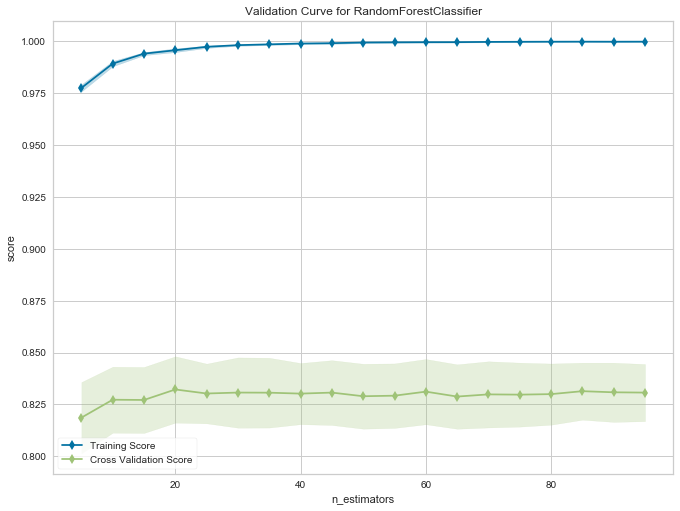

In [7]:
rf_test = RandomForestClassifier(n_estimators=100, random_state=42)
val_curve_wrapper(rf_test, x_train.drop('local_student_id', axis=1), y_train, groups=x_train['local_student_id'], 
                  param='n_estimators', min=5, max=100, step=5)

20 estimators is optimal

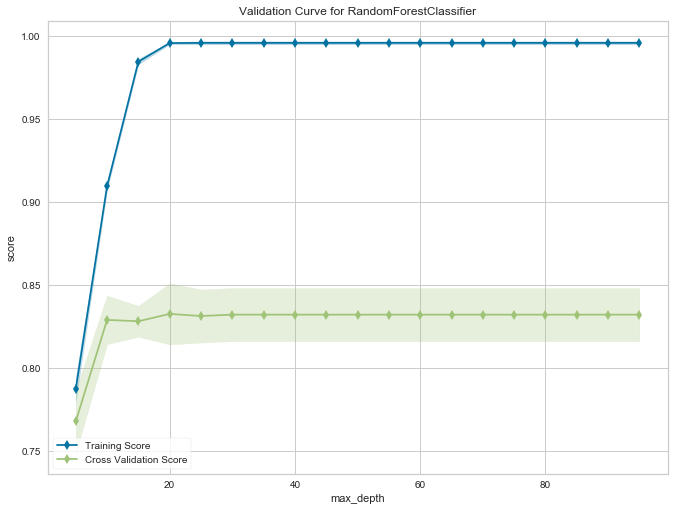

In [8]:
rf_test = RandomForestClassifier(n_estimators=20, random_state=42)
val_curve_wrapper(rf_test, x_train.drop('local_student_id', axis=1), y_train, groups=x_train['local_student_id'], 
                  param='max_depth', min=5, max=100, step=5)

Maximum depth of 30 or more is optimal

# Run model

In [9]:
x_train = x_train.drop(['local_student_id'], axis=1)
x_test = x_test.drop(['local_student_id'], axis=1)

rf = RandomForestClassifier(n_estimators=20, random_state=42)
rf.fit(x_train, y_train)

probabilities = rf.predict_proba(x_test)
preds = rf.predict(x_test)
report = classification_report(y_test, preds, labels=[True, False])
feature_importances = rf.feature_importances_
cm = confusion_matrix(y_test, preds, labels=[True, False])

weights = pd.DataFrame({'variable': x_train.columns,
                        'feature_importance': feature_importances})

cm = pd.DataFrame(data=cm, columns=['accepted_predicted',
                                    'denied_predicted'])
cm['outcome'] = ['accepted_actual', 'denied_actual']
cm = cm[['outcome', 'accepted_predicted', 'denied_predicted']]

predictions = x_test.merge(y_test, how='left', left_index=True,
                           right_index=True)
predictions['predicted_outcome'] = preds
predictions['probability_of_acceptance'] = probabilities[:, 1]
predictions = predictions.merge(df[[
                                    'local_student_id',
                                    'ClassOf',
                                    'naviance_college_id',
                                    'application_results_status',
                                    'UNITID',
                                    'Institution_entity_name',
                                ]], how='left', left_index=True,
                                right_index=True)

predictions.sort_values(by='probability_of_acceptance', ascending=False).head(20)

,gpa_unweighted_scaled,composite_act_scaled,institutional_average_test_score_scaled,Institutional_Average_Admissions_total_Percentage,outcome,predicted_outcome,probability_of_acceptance,local_student_id,ClassOf,naviance_college_id,application_results_status,UNITID,Institution_entity_name
12356,0.8125,0.914286,0.695238,0.685018,True,True,1.0,111111112,2019.0,1111,accepted,228787.0,The University of Texas at Dallas
8978,0.6575,0.400000,0.485714,0.427035,True,True,1.0,111111113,2017.0,1112,accepted,224554.0,Texas A & M University-Commerce
4508,0.8850,0.685714,0.628571,0.597906,True,True,1.0,111111114,2017.0,1113,accepted,225511.0,University of Houston
4507,0.8850,0.685714,0.647619,0.520709,True,True,1.0,111111114,2017.0,1114,accepted,224323.0,University of Dallas
4506,0.8850,0.685714,0.447619,0.999907,True,True,1.0,111111114,2017.0,1115,accepted,228796.0,The University of Texas at El Paso
4505,0.8850,0.685714,0.457143,0.858385,True,True,1.0,111111114,2017.0,1116,accepted,229179.0,Texas Woman's University
4503,0.8850,0.685714,0.514286,0.414801,True,True,1.0,111111114,2017.0,1117,accepted,224226.0,Dallas Baptist University
4501,0.6425,0.542857,0.457143,0.858385,False,True,1.0,111111115,2017.0,1116,denied,229179.0,Texas Woman's University
8968,0.9225,0.600000,0.628571,0.892929,True,True,1.0,111111116,2018.0,1117,accepted,102049.0,Samford University
8973,0.9225,0.600000,0.676190,0.681165,True,True,1.0,111111116,2018.0,1118,accepted,228723.0,Texas A & M University-College Station


# Model evaluation metrics

In [10]:
weights

,variable,feature_importance
0,gpa_unweighted_scaled,0.301624
1,composite_act_scaled,0.208365
2,institutional_average_test_score_scaled,0.247459
3,Institutional_Average_Admissions_total_Percentage,0.242552


In [11]:
cm

,outcome,accepted_predicted,denied_predicted
0,accepted_actual,1669,198
1,denied_actual,177,431


In [12]:
print(report)

              precision    recall  f1-score   support

        True       0.90      0.89      0.90      1867
       False       0.69      0.71      0.70       608

    accuracy                           0.85      2475
   macro avg       0.79      0.80      0.80      2475
weighted avg       0.85      0.85      0.85      2475

